<a href="https://colab.research.google.com/github/Alex-Chen1121/Deep-Leaning/blob/main/8_7_PyTorch_TSNE_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **判斷分類是否分的好**



In [ ]:
# Basic module
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # progress bar

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms # 資料前處理

In [ ]:
# print version of PyTorch
torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

執行階段 -> 變更執行階段類型

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


#### Prepare MNIST Dataset

0~9

In [ ]:
# Define Parameters
NUM_CLASS = 10
# Class name and class mapping
class_names = [str(i) for i in range(10)]
class_map = {cls: i for i, cls in enumerate(class_names)}
print(class_map)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


#### torch.utils.data.Dataset

https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset

*   read **1** sample (img, label)
*   Convert to **Torch.Tensor**
* Datasets provided by torchvision https://pytorch.org/vision/stable/datasets.html


In [ ]:
# Download dataset
train_ds = torchvision.datasets.MNIST('data', # saved path
    train=True, # training or testing set
    download=True # download dataset from internet
)
val_ds = torchvision.datasets.MNIST('data',
    train=False,
    download=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 102868926.93it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29617529.05it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26477379.01it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15000416.35it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Check your dataset
print('Number of training   samples:', len(train_ds))
print('Number of validation samples:', len(val_ds))

Number of training   samples: 60000
Number of validation samples: 10000


In [ ]:
lable, data = train_ds[0]
data

5

In [ ]:
# Random select a sample
idx = np.random.randint(low=0, high=len(train_ds))
img, label = train_ds[idx]

# Type of img and label
print(idx)
print(type(img), type(label))

26749
<class 'PIL.Image.Image'> <class 'int'>


img shape:  (28, 28)
label:  7
class name:  7


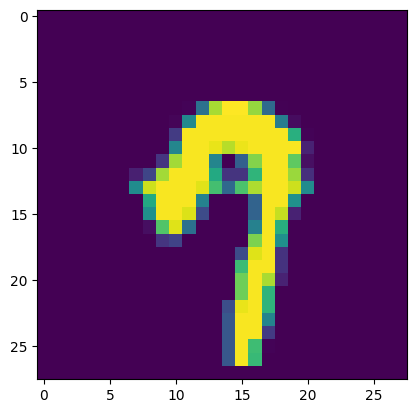

In [ ]:
# Convert to np.ndarray and show image
img_np = np.array(img)
print('img shape: ', img_np.shape)
print('label: ', label)
print('class name: ', class_names[label])
plt.imshow(img_np)
plt.show()

#### Data Proprocess



1.   Convert **PIL.Image** to **torch.FloatTensor** (張量)
  

*   Converts a **PIL Image or numpy.ndarray** (H, W, C) in the range [0, 255] to a **torch.FloatTensor** of shape (C, H, W) in the range [0.0, 1.0]

2.   TODO: Data Augmentation, ... etc



In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(), # Convert to Tensor
    # ...
])

In [ ]:
# Build dataset with data preprocess
train_ds = torchvision.datasets.MNIST('data',
    train=True,
    download=True,
    transform=preprocess)
val_ds = torchvision.datasets.MNIST('data',
    train=False,
    download=True,
    transform=preprocess)

In [ ]:
# Random select a sample
idx = np.random.randint(low=0, high=len(train_ds))
img, label = train_ds[idx]

# Type of img and label
print(idx)
print(type(img), type(label))
print(img.shape)

23765
<class 'torch.Tensor'> <class 'int'>
torch.Size([1, 28, 28])


#### Combine Dataset with DataLoader

**torch.utils.data.DataLoader**: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

* form a **batch**
* data sampler
* reading order (shuffle)

In [ ]:
# Use DataLoader to generate minibatches
BATCH_SIZE = 256
train_dataloader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_dataloader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=BATCH_SIZE)

Check shape of data

N: number of samples

C: channels

H: Height

W: Width

**PyTorch use channel first !**

In [ ]:
for x, y in train_dataloader:
    print("type ", type(x), type(y))
    print("Shape of x [N, C, H, W]: ", x.shape, x.dtype)
    print("Shape of y [N]: ", y.shape, y.dtype)
    break

type  <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of x [N, C, H, W]:  torch.Size([256, 1, 28, 28]) torch.float32
Shape of y [N]:  torch.Size([256]) torch.int64


(<matplotlib.image.AxesImage at 0x7d05322018d0>, tensor(9))

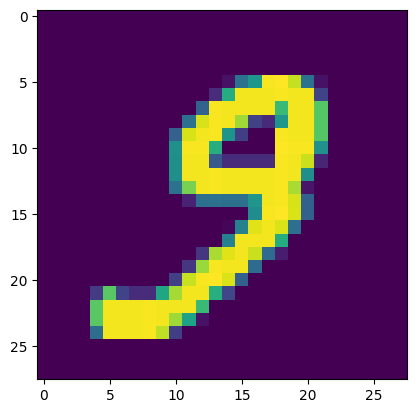

In [ ]:
# permute: [C, H, W] -> [H, W, C]
plt.imshow(x[0].permute(1, 2, 0)), y[0]

#### Build Model

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

IMG_SIZE = 28

Using device: cpu


nn.Module Subclass

In [ ]:
# Define model
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(7*7*32, 10),
        )
    def feature(self, x):
        return self.encoder(x)

    def forward(self, x):
        x = self.feature(x)
        logits = self.classifier(x)
        return logits

In [ ]:
# init model and move to GPU device
model = NeuralNet().to(device)

In [ ]:
# 確認輸出的數值對不對
inputs = torch.randn(1, 1, 28, 28).to(device)
outputs = model(inputs) # forward

outputs = model.feature(inputs)
outputs.shape

torch.Size([1, 1568])

#### Training: Optimizing the Model Parameters

In [ ]:
loss_fn = nn.CrossEntropyLoss() # Softmax + negative log likelihood loss (nn.NLLLoss)
optimizer = torch.optim.Adam(
    params=model.parameters()
)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to device

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
EPOCHS = 10
logs = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_dataloader, model, loss_fn)

    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 0.4000, train_acc: 0.882     val_loss: 0.0855, val_acc: 0.972 


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 1     train_loss: 0.0755, train_acc: 0.977     val_loss: 0.0513, val_acc: 0.982 


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 2     train_loss: 0.0527, train_acc: 0.984     val_loss: 0.0412, val_acc: 0.986 


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 3     train_loss: 0.0425, train_acc: 0.987     val_loss: 0.0339, val_acc: 0.989 


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#### Evaluation

In [ ]:
_ = model.eval()

In [ ]:
features = []
labels = []

with torch.no_grad():
    for x, y in tqdm(val_dataloader):
        x = x.to(device)
        feature = model.feature(x)
        features.append(feature) # 加上特徵向量
        labels.append(y) # y是答案

features = torch.cat(features, dim=0).cpu().numpy() # concat的方向 dim=0
labels = torch.cat(labels, dim=0).numpy()

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
feature

tensor([[0.0000, 0.0000, 0.0000,  ..., 1.7830, 0.0707, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.7167, 0.3675],
        [0.0000, 0.0000, 0.0000,  ..., 1.7849, 1.9670, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.5923, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.8478, 0.2923, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.8675, 0.8300, 0.0000]])

In [ ]:
features.shape, labels.shape

((10000, 1568), (10000,))

In [ ]:
from sklearn import manifold

N_SAMPLES = 2000

x_tsne = manifold.TSNE(n_components=2,
                       init='random',
                       random_state=5566,
                       verbose=1).fit_transform(features[:N_SAMPLES])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.743s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 17.960968
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.735825
[t-SNE] KL divergence after 1000 iterations: 1.021140


In [ ]:
# PCA
import sklearn
x_pca = sklearn.decomposition.PCA(n_components=2).fit_transform(features[:N_SAMPLES])

In [ ]:
x_tsne.shape, x_pca.shape

((2000, 2), (2000, 2))

In [ ]:
def plot(x, labels, title):
    # normalize
    x_min, x_max = x.min(0), x.max(0)
    x_norm = (x - x_min) / (x_max - x_min)

    plt.figure(figsize=(8, 8))
    cmap = plt.cm.get_cmap("tab20", 10)

    for digit in range(10):
        idx = labels[:N_SAMPLES] == digit
        plt.scatter(x_norm[idx, 0],
                    x_norm[idx, 1],
                    color=cmap(digit),
                    label=digit,
                    alpha=0.3)

    plt.title(title)
    plt.legend()
    plt.show()

<ipython-input-29-7f5ecc87a878>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", 10)


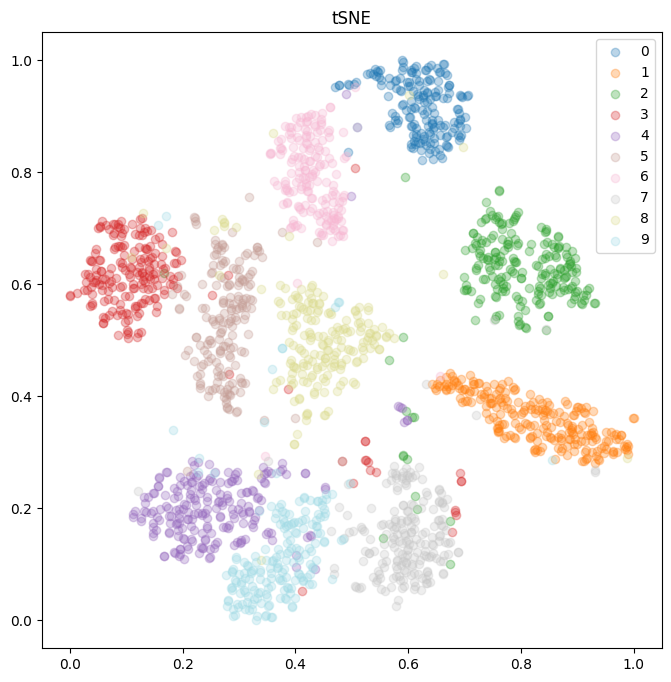

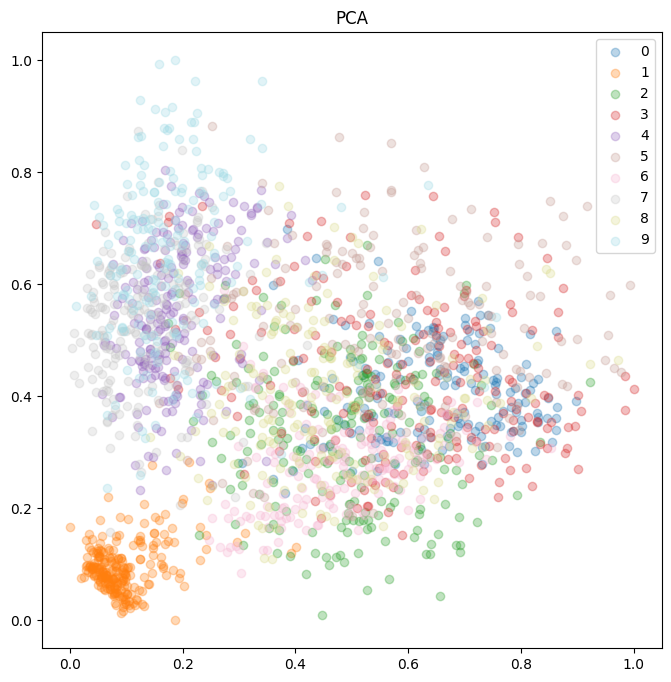

In [ ]:
plot(x_tsne, labels, 'tSNE')
plot(x_pca, labels, 'PCA')

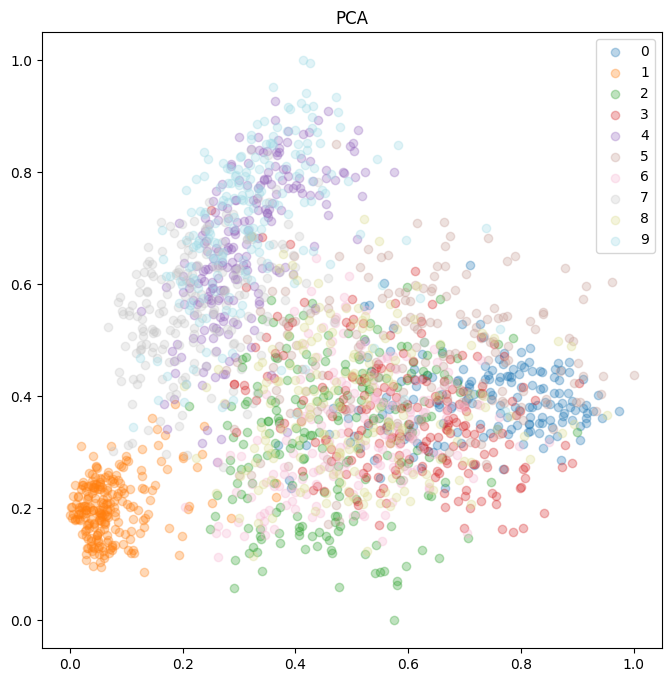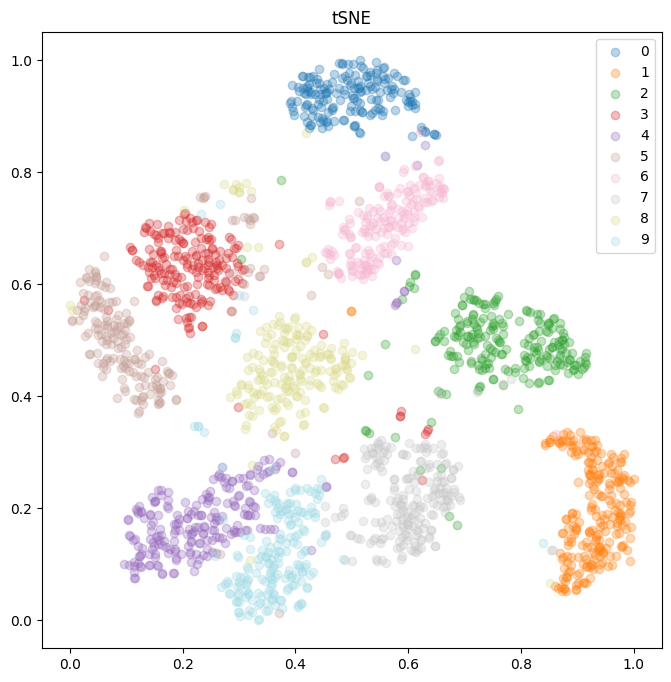